<a href="https://colab.research.google.com/github/rahiakela/gans-in-action/blob/part-1-introduction-to-gans-and-generative-modeling/chapter_4_generating_handwritten_digits_using_deep_convolutional_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating handwritten digits using Deep Convolutional GAN

We will implement a GAN that learns to produce realistic-looking handwritten digits. We will use the Python neural network library Keras with a TensorFlow backend.

Over the course of the training iterations, the Generator learns to turn random noise input into images that look like members of the training data: the MNIST dataset of handwritten digits. 

Now we will revisit the MNIST dataset of handwritten digits from last chapter.This time, however, we will use the DCGAN architecture and represent both the Generator and the Discriminator as convolutional networks

<img src='https://github.com/rahiakela/img-repo/blob/master/gans-in-action/gan-network.png?raw=1' width='800'/>

Besides this change, the rest of the network architecture remains unchanged. At the end of the tutorial, we will compare the quality of the handwritten numerals produced by the two GANs (traditional versus DCGAN) so you can see the improvement made possible by the use of a more advanced network architecture.



## Setup

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Flatten, Reshape, LeakyReLU, Activation, BatchNormalization, Dropout, Conv2D, Conv2DTranspose)
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.datasets import  mnist

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

We specify the input dimensions of our model and dataset. Each image in MNIST is 28 × 28 pixels with a single channel (because the images are grayscale). The variable z_dim sets the size of the noise vector, z.

In [0]:
img_rows = 28
img_cols = 28
channels = 1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 100

##  Implementing the Generator

ConvNets have traditionally been used for image classification tasks, in which the network takes in an image with the dimensions height × width × number of color channels as input and—through a series of convolutional layers—outputs a single vector of class scores, with the dimensions 1 × n, where n is the number of class labels. To generate an image by using the ConvNet architecture, we reverse the process: instead of taking an image and processing it into a vector, we take a vector and up-size it to an image.

**Key to this process is the transposed convolution. Recall that regular convolution is typically used to reduce input width and height while increasing its depth. Transposed convolution goes in the reverse direction: it is used to increase the width and height while reducing depth.**

<img src='https://github.com/rahiakela/img-repo/blob/master/gans-in-action/dcgan-1.png?raw=1' width='800'/>

The Generator starts with a noise vector z. Using a fully connected layer, we reshape the vector into a three-dimensional hidden layer with a small base (width × height) and large depth. Using transposed convolutions, the input is progressively reshaped such that its base grows while its depth decreases until we reach the final layer with the shape of the image we are seeking to synthesize, 28 × 28 × 1.

After each transposed convolution layer, we apply batch normalization and the Leaky ReLU activation function. At the final layer, we do not apply batch normalization and, instead of ReLU, we use the tanh activation function.

Putting all the steps together, we do the following:

1. Take a random noise vector and reshape it into a 7 × 7 × 256 tensor through a fully connected layer.
         
2. Use transposed convolution, transforming the 7 × 7 × 256 tensor into a 14 × 14 × 128 tensor.
         
3. Apply batch normalization and the Leaky ReLU activation function. 
         
4. Use transposed convolution, transforming the 14 × 14 × 128 tensor into a 14 × 14 × 64 tensor. Notice that the width and height dimensions remain unchanged; this is accomplished by setting the stride parameter in Conv2DTranspose to 1.
         
5. Apply batch normalization and the Leaky ReLU activation function.

6. Use transposed convolution, transforming the 14 × 14 × 64 tensor into the output image size, 28 × 28 × 1.
         
7. Apply the tanh activation function.



In [0]:
def build_generator(z_dim):
  model = Sequential()

  # 1. Reshape input into 7x7x256 tensor via a fully connected layer
  model.add(Dense(256 * 7 * 7, input_dim=z_dim))
  model.add(Reshape((7, 7, 256)))

  # 2. Transposed convolution layer, from 7x7x256 into 14x14x128 tensor
  model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='SAME'))

  # 3. Batch normalization & Leaky ReLU activation
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))

  # 4. Transposed convolution layer, from 14x14x128 to 14x14x64 tensor
  model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='SAME'))

  # 5. Batch normalization & Leaky ReLU activation
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))

  # 6. Transposed convolution layer, from 14x14x64 to 28x28x1 tensor
  model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='SAME'))

  # 7. Output layer with tanh activation
  model.add(Activation('tanh'))

  return model

## Implementing the Discriminator

The Discriminator is a ConvNet of the familiar kind, one that takes in an image and outputs a prediction vector: in this case, a binary classification indicating whether the input image was deemed to be real rather than fake. 

<img src='https://github.com/rahiakela/img-repo/blob/master/gans-in-action/dcgan-2.png?raw=1' width='800'/>

The input to the Discriminator is a 28 × 28 × 1 image. By applying convolutions, the image is transformed such that its base (width × height) gets progressively smaller and its depth gets progressively deeper. On all convolutional layers, we apply the Leaky ReLU activation function. Batch normalization is used on all convolutional layers except the first. For output, we use a fully connected layer and the sigmoid activation function.

Putting all the steps together, we do the following:

1. Use a convolutional layer to transform a 28 × 28 × 1 input image into a 14 × 14 × 32 tensor.
         
2. Apply the Leaky ReLU activation function.
         
3. Use a convolutional layer, transforming the 14 × 14 × 32 tensor into a 7 × 7 × 64 tensor.
         
4. Apply batch normalization and the Leaky ReLU activation function.
         
5. Use a convolutional layer, transforming the 7 × 7 × 64 tensor into a 3 × 3 × 128 tensor.
         
6. Apply batch normalization and the Leaky ReLU activation function.
         
7. Flatten the 3 × 3 × 128 tensor into a vector of size 3 × 3 × 128 = 1152.

8. Use a fully connected layer feeding into the sigmoid activation function to compute the probability of whether the input image is real.

In [0]:
def build_discriminator(img_shape):
  model = Sequential()

  # 1. Convolutional layer, from 28x28x1 into 14x14x32 tensor
  model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding='SAME'))

  # 2. Leaky ReLU activation
  model.add(LeakyReLU(alpha=0.01))

  # 3. Convolutional layer, from 14x14x32 into 7x7x64 tensor
  model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=img_shape, padding='SAME'))

  # 4. Batch normalization & Leaky ReLU activation
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))

  # 5. Convolutional layer, from 7x7x64 tensor into 3x3x128 tensor
  model.add(Conv2D(128, kernel_size=3, strides=2, input_shape=img_shape, padding='SAME'))

  # 6. Batch normalization & Leaky ReLU activation
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))

  # 7. Flatten the 3 × 3 × 128 tensor into a vector of size 3 × 3 × 128 = 1152.
  model.add(Flatten())

  # 8. Output layer with sigmoid activation
  model.add(Dense(1, activation='sigmoid'))

  return model

## Building the model

Aside from the network architectures used for the Generator and the Discriminator, the rest of the DCGAN network setup and implementation is the same as the one we used for the simple GAN.

We use binary cross-entropy as the loss function we are seeking to minimize during training. Binary cross-entropy is a measure of the difference between computed probabilities and actual probabilities for predictions with only two possible classes. The greater the cross-entropy loss, the further away our predictions are from the true labels.

To optimize each network, we use the Adam optimization algorithm. This algorithm, whose name is derived from adaptive moment estimation, is an advanced gradient-descent-based optimizer. Adam has become the go-to optimizer for most GAN implementations thanks to its often superior performance.

In [0]:
def build_gan(generator, discriminator):
  model = Sequential()

  # Combined Generator -> Discriminator model
  model.add(generator)
  model.add(discriminator)

  return model

# Build and compile the Discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Build the Generator
generator = build_generator(z_dim)

# Keep Discriminator’s parameters constant for Generator training
discriminator.trainable = False

# Build and compile GAN model with fixed Discriminator to train the Generator
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

## Training GAN

We get a random mini-batch of MNIST images as real examples and generate a mini-batch of fake images from random noise vectors z. We then use those to train the Discriminator network while keeping the Generator’s parameters constant. 

Next we generate a mini-batch of fake images and use those to train the Generator network while keeping the Discriminator’s parameters fixed.
We repeat this for each iteration.

We use one-hot-encoded labels: 1 for real images and 0 for fake ones. To generate z, we sample from the standard normal distribution (a bell curve with 0 mean and a standard deviation of 1). 

The Discriminator is trained to assign fake labels to the fake images and real labels to real images. The Generator is trained such that the Discriminator assigns real labels to the fake examples it produces.

Notice that we are rescaling the real images in the training dataset from –1 to 1. As you saw in the preceding example, the Generator uses the tanh activation function at the output layer, so the fake images will be in the range (–1, 1). Accordingly, we have to rescale all the Discriminator’s inputs to the same range.

In [0]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
  # Load the MNIST dataset
  (X_train, _), (_, _) = mnist.load_data()

  # Rescale [0, 255] grayscale pixel values to [-1, 1]
  X_train = X_train / 127.5 - 1.0
  X_train = np.expand_dims(X_train, axis=3)

  # Labels for real images: all ones
  real = np.ones((batch_size, 1))

  # Labels for fake images: all zeros
  fake = np.zeros((batch_size, 1))

  for iteration in range(iterations):

    # -------------------------
    #  Train the Discriminator
    # -------------------------

    # Get a random batch of real images
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    # Generate a batch of fake images
    z = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(z)

    # Train Discriminator
    d_loss_real = discriminator.train_on_batch(imgs, real)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    #  Train the Generator
    # ---------------------

    # Generate a batch of fake images
    z = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(z)

    # Train Generator
    g_loss = gan.train_on_batch(z, real)

    if (iteration + 1) % sample_interval == 0:
      # Save losses and accuracies so they can be plotted after training
      losses.append((d_loss, g_loss))
      accuracies.append(100.0 * accuracy)
      iteration_checkpoints.append(iteration + 1)

      # Output training progress
      print('%d [Discriminator loss: %f, accuracy: %.2f%%] [Generator loss: %f]' % (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

      # Output a sample of generated image
      sample_images(generator)

This function gets called every sample_interval iterations and outputs a 4 × 4 grid of images synthesized by the Generator in the given iteration. After we run our model, we will use these images to inspect interim and final outputs.

In [0]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):
  # Sample random noise
  z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

  # Generate images from random noise
  gen_imgs = generator.predict(z)

  # Rescale image pixel values to [0, 1]
  gen_imgs = 0.5 * gen_imgs + 0.5

  # Set image grid
  fig, axs = plt.subplots(image_grid_rows, image_grid_columns, figsize=(4, 4), sharey=True, sharex=True)

  cnt = 0
  for i in range(image_grid_rows):
    for j in range(image_grid_columns):
      # Output a grid of images
      axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
      axs[i, j].axis('off')
      cnt +=1

## Running the model

We set the training hyperparameters—the number of iterations and the batch size—and train the model. There is no tried-and-true method to determine the right number of iterations or the right batch size; we determine them experimentally through trial and error as we observe the training progress.

That said, there are important practical constraints to these numbers: each mini-batch must be small enough to fit inside the processing memory (typical batch sizes people use are powers of 2: 32, 64, 128, 256, and 512). 

The number of iterations also has a practical constraint: the more iterations we have, the longer the training process takes. With complex deep learning models like GANs, this can get out of hand quickly, even with significant computing power.

To determine the right number of iterations, we monitor the training loss and set the iteration number around the point when the loss plateaus, indicating that we are getting little to no incremental improvement from further training.

Note that the **Discrepancy between trainable weights and collected trainable** warning from Keras is expected. It is by design: The Generator's trainable parameters are intentionally held constant during Discriminator training, and vice versa.

11493376/11490434 [==============================] - 0s 0us/step
1000 [Discriminator loss: 0.000005, accuracy: 100.00%] [Generator loss: 0.003562]
2000 [Discriminator loss: 0.000002, accuracy: 100.00%] [Generator loss: 0.001386]
3000 [Discriminator loss: 0.000001, accuracy: 100.00%] [Generator loss: 0.002184]
4000 [Discriminator loss: 0.000000, accuracy: 100.00%] [Generator loss: 0.006921]
5000 [Discriminator loss: 0.000000, accuracy: 100.00%] [Generator loss: 0.026858]
6000 [Discriminator loss: 0.000000, accuracy: 100.00%] [Generator loss: 0.013019]
7000 [Discriminator loss: 0.000000, accuracy: 100.00%] [Generator loss: 0.020007]
8000 [Discriminator loss: 0.000000, accuracy: 100.00%] [Generator loss: 0.014263]
9000 [Discriminator loss: 0.000000, accuracy: 100.00%] [Generator loss: 0.020235]
10000 [Discriminator loss: 0.000000, accuracy: 100.00%] [Generator loss: 0.017140]
11000 [Discriminator loss: 0.000000, accuracy: 100.00%] [Generator loss: 0.027510]
12000 [Discriminator loss: 0.00

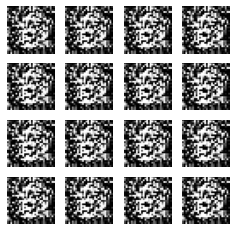

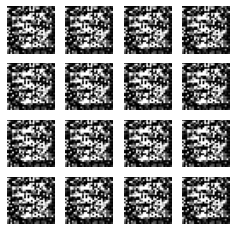

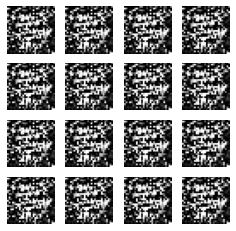

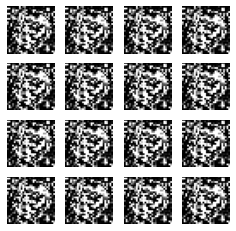

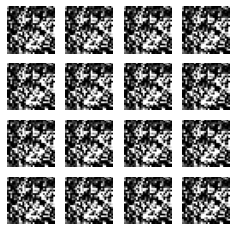

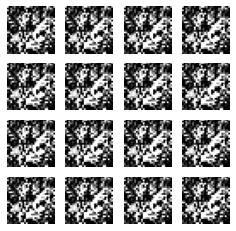

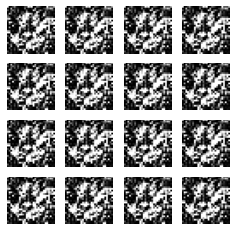

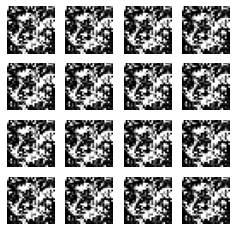

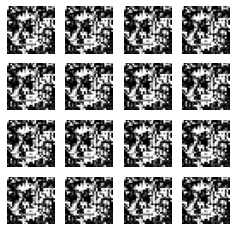

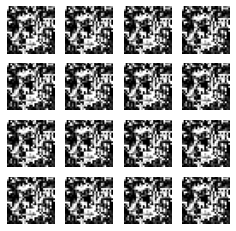

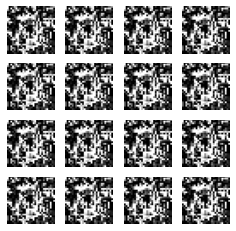

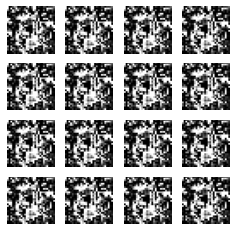

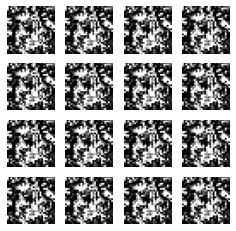

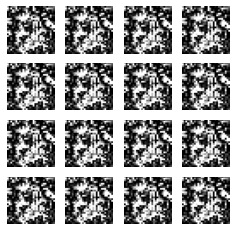

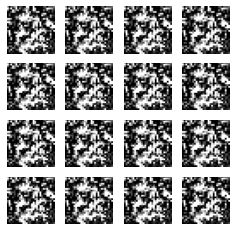

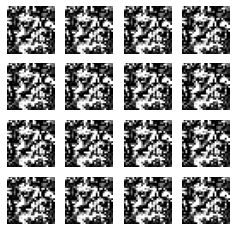

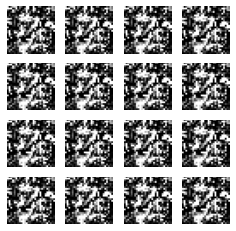

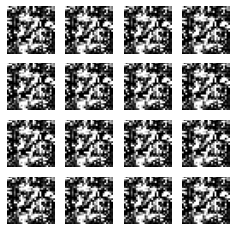

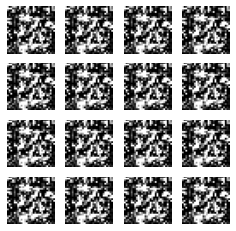

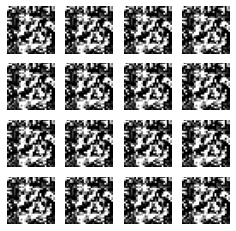

In [10]:
# Set hyperparameters
iterations = 20000
batch_size = 128
sample_interval = 1000

# Train the GAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

As you can see, the Generator starts out by producing little more than random noise. Over the course of the training iterations, it gets better and better at emulating the features of the training data. Each time the Discriminator rejects a generated image as false or accepts one as real, the Generator improves a little.

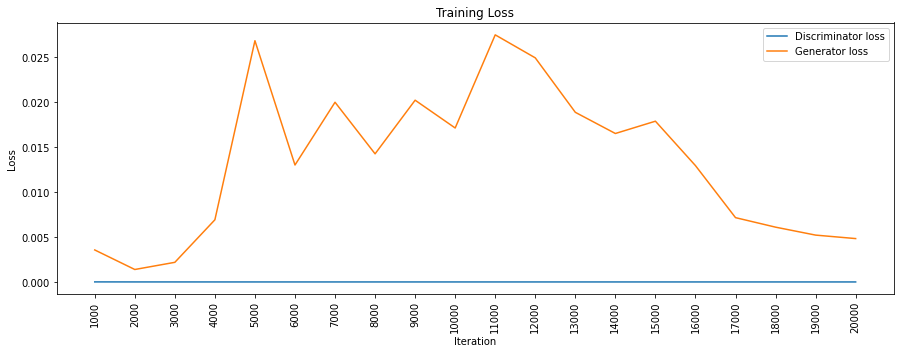

In [11]:
losses = np.array(losses)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

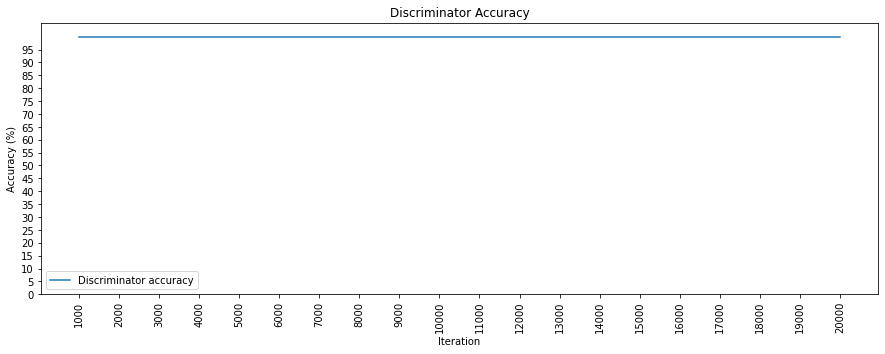

In [12]:
accuracies = np.array(accuracies)

# Plot Discriminator accuracy
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()

As evidenced by the preceding figures, all the extra work we put into implementing DCGAN paid off handsomely. Many of the images of handwritten digits that the network produces after being fully trained are virtually indistinguishable from the ones written by a human hand.

## Conclusion

DCGAN demonstrates the versatility of the GAN framework. In theory, the Discriminator and Generator can be represented by any differentiable function, even one as complex as a multilayer convolutional network. 

However, DCGAN also demonstrates that there are significant hurdles to making more complex implementations work in practice. Without breakthroughs such as batch normalization, DCGAN would fail to train properly.

